In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import os
import geopandas as gpd
import contextily as ctx
from dataclasses import dataclass
import numpy as np
from scipy.integrate import odeint 
from IPython.core.getipython import get_ipython

notebook_path = os.path.join(os.getcwd(), get_ipython().starting_dir)
current_dir = os.path.dirname(notebook_path)

CLEANED_DATA_PATH = os.path.join(current_dir, 'data/processed/cleaned_data.csv')
SHAPERAW_DATA_PATH = os.path.join(current_dir, 'data/processed/shapefile/shapefile.shp')


pd.read_csv(CLEANED_DATA_PATH).head()




,Zip Code,Number of Households,Number of Families,Number of Families with Children,Number of Families with NO Children,Families with no Earners,Percent Distribution of Families,Percent Distribution of Families with Children,Percent Distribution of Families with NO Children,Median Income of all Households,Median Income of all Families
0,10001,14273,4256,1543,2713,329,4256,36.3,63.7,101409,142042.0
1,10002,34737,16914,4650,12264,5433,16914,27.5,72.5,37093,38815.0
2,10003,25181,6855,2057,4798,786,6855,30.0,70.0,137533,219957.0
3,10004,2113,1062,605,457,37,1062,57.0,43.0,216017,247237.0
4,10005,4782,1311,635,676,0,1311,48.4,51.6,197188,250000.0


Accuracy: 0.7555555555555555
ROC AUC Score: 0.0


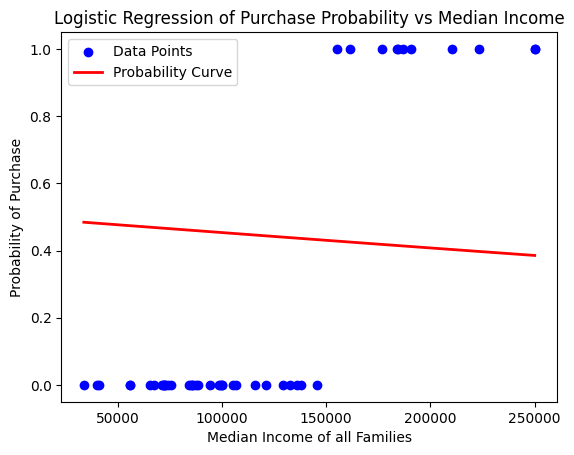

In [69]:
data = pd.read_csv(CLEANED_DATA_PATH)

data['Median Income of all Families'] = data['Median Income of all Families'].astype(str)

# Handle the special case where income is represented as '250,000+'
data['Median Income of all Families'] = data['Median Income of all Families'].replace('250,000+', '250000')

# Convert the column to numeric, coercing errors to NaN
data['Median Income of all Families'] = pd.to_numeric(data['Median Income of all Families'], errors='coerce')

# Assume an arbitrary income threshold to simulate purchase likelihood
income_threshold = 150000  # Adjust this threshold based on your understanding of the data
data['Purchase_Likelihood'] = (data['Median Income of all Families'] > income_threshold).astype(int)

# Handle missing values by dropping them
data.dropna(subset=['Median Income of all Families'], inplace=True)

# Prepare the data for training
X = data[['Median Income of all Families']].values.reshape(-1, 1)
y = data['Purchase_Likelihood']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the trained logistic regression model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # AUC score is a good performance metric for binary classifiers

# Print out the model evaluation results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC Score: {roc_auc}")

# Plot the results of the logistic regression
# Sort the values to ensure a continuous line plot for probabilities
sorted_indices = X_test.argsort(axis=0).flatten()
X_test_sorted = X_test[sorted_indices]
y_pred_proba_sorted = y_pred_proba[sorted_indices]

plt.scatter(X_test, y_test, color='blue', label='Data Points')
plt.plot(X_test_sorted, y_pred_proba_sorted, color='red', linewidth=2, label='Probability Curve')
plt.xlabel('Median Income of all Families')
plt.ylabel('Probability of Purchase')
plt.title('Logistic Regression of Purchase Probability vs Median Income')
plt.legend()
plt.show()

#

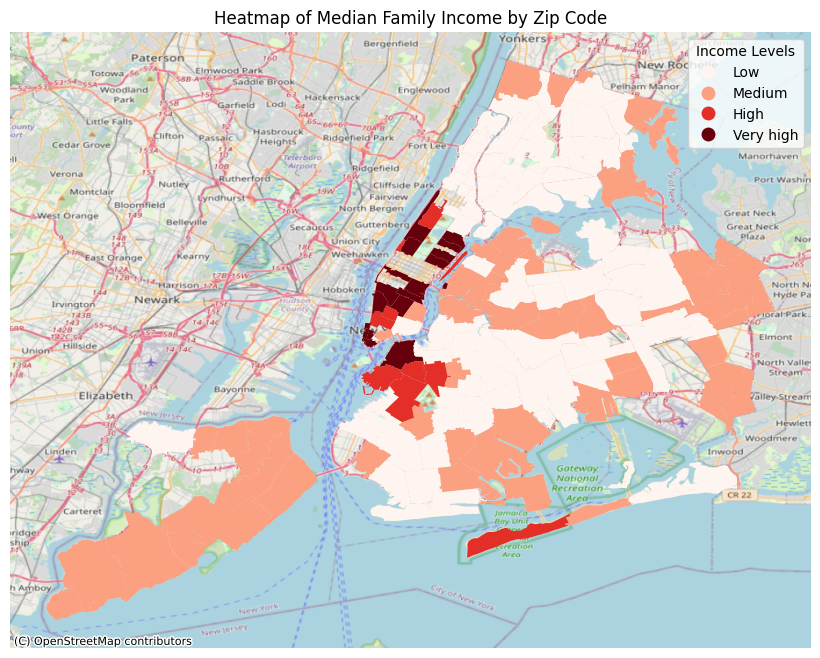

In [70]:
import geopandas as gpd
SHAPERAW_DATA_PATH = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/raw/Modified Zip Code Tabulation Areas (MODZCTA)/geo_export_152003af-efec-4038-9b6f-1963116a24c2.shp'
gdf = gpd.read_file(SHAPERAW_DATA_PATH)

gdf['zcta'] = gdf['zcta'].astype(str)
data['Zip Code'] = data['Zip Code'].astype(str)
merged = gdf.merge(data, left_on='zcta', right_on='Zip Code')
merged['Median Income of all Families'] = pd.to_numeric(merged['Median Income of all Families'], errors='coerce')
merged['Median Income of all Families'].fillna(merged['Median Income of all Families'].median(), inplace=True)
merged['Income Level'] = pd.cut(merged['Median Income of all Families'], bins=4, labels=["Low", "Medium", "High", "Very high"])

# Plot the merged data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(column='Income Level', ax=ax, legend=True, cmap='Reds', categorical=True)
leg = ax.get_legend()
leg.set_title('Income Levels')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=merged.crs.to_string())
ax.set_axis_off()
plt.title('Heatmap of Median Family Income by Zip Code')
plt.show()

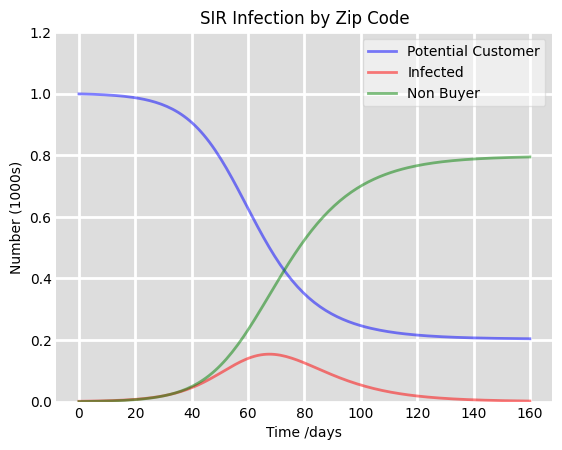

In [71]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint


def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


@dataclass
class SIRDiagram:
    n: int = 1000
    i: int = 1
    r: int = 0
    beta: float = 0.2
    gamma: float = 1.0 / 10
    steps: int = 160

    def s(self) -> int:
        return self.n - self.i - self.r

    def plot(self):
        t = np.linspace(0, self.steps, self.steps)
        y0 = self.s(), self.i, self.r
        N, beta, gamma = self.n, self.beta, self.gamma
        ret = odeint(deriv, y0, t, args=(N, beta, gamma))
        S, I, R = ret.T

        fig = plt.figure(facecolor="w")
        ax = fig.add_subplot(111, facecolor="#dddddd", axisbelow=True)
        ax.plot(t, S / 1000, "b", alpha=0.5, lw=2, label="Potential Customer")
        ax.plot(t, I / 1000, "r", alpha=0.5, lw=2, label="Infected")
        ax.plot(t, R / 1000, "g", alpha=0.5, lw=2, label="Non Buyer")

        ax.set_xlabel("Time /days")
        ax.set_ylabel("Number (1000s)")
        ax.set_ylim(0, 1.2)
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(which="major", c="w", lw=2, ls="-")
        legend = ax.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ("top", "right", "bottom", "left"):
            ax.spines[spine].set_visible(False)

        plt.title("SIR Infection by Zip Code")
        plt.show()


def main():
    diagram = SIRDiagram()
    diagram.plot()


if __name__ == "__main__":
    main()

In [72]:
"""
This script reads a CSV file and prints the second column.
"""

import pandas as pd

RAW_DATA_PATH = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/raw/ACSST5Y2021.S1903_2023-11-14T204901/data.csv'
META_DATA_PATH = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/raw/ACSST5Y2021.S1903_2023-11-14T204901/metadata.csv'
metadf = pd.read_csv(META_DATA_PATH)
print(metadf.columns)

df = pd.read_csv(RAW_DATA_PATH)
print(df.columns) 

#ok to the Column name in Metadata is in Data, the label is what the codes mean, lets rename the columns



Index(['Column Name', 'Label'], dtype='object')
Index(['GEO_ID', 'NAME', 'S1903_C01_001E', 'S1903_C01_001EA', 'S1903_C01_001M',
       'S1903_C01_001MA', 'S1903_C01_002E', 'S1903_C01_002M',
       'S1903_C01_002MA', 'S1903_C01_002EA',
       ...
       'S1903_C03_038MA', 'S1903_C03_039E', 'S1903_C03_039EA',
       'S1903_C03_039M', 'S1903_C03_039MA', 'S1903_C03_040E',
       'S1903_C03_040EA', 'S1903_C03_040M', 'S1903_C03_040MA', 'Unnamed: 482'],
      dtype='object', length=483)


/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/l

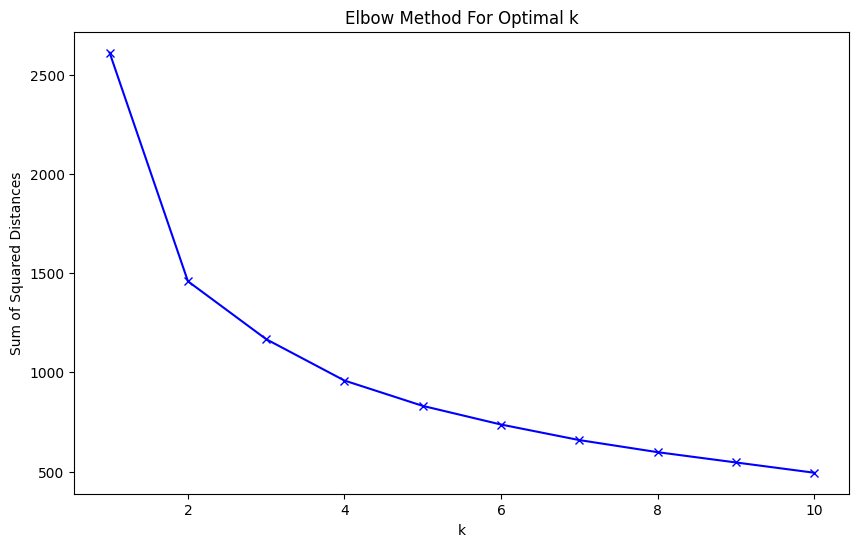

/Users/alejandrodiaz/Documents/GitHub/DS_Project/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


         Number of Households  Number of Families  \
Cluster                                             
0                29429.058824        18906.294118   
1                 3756.352941         2115.188235   
2                16778.082353         9798.764706   
3                 7540.700000         4425.525000   

         Number of Families with Children  \
Cluster                                     
0                             8101.568627   
1                              731.494118   
2                             3774.470588   
3                             1967.450000   

         Number of Families with NO Children  Families with no Earners  \
Cluster                                                                  
0                               10804.725490               2661.254902   
1                                1383.694118                264.552941   
2                                6024.294118               1175.988235   
3                                2458.07

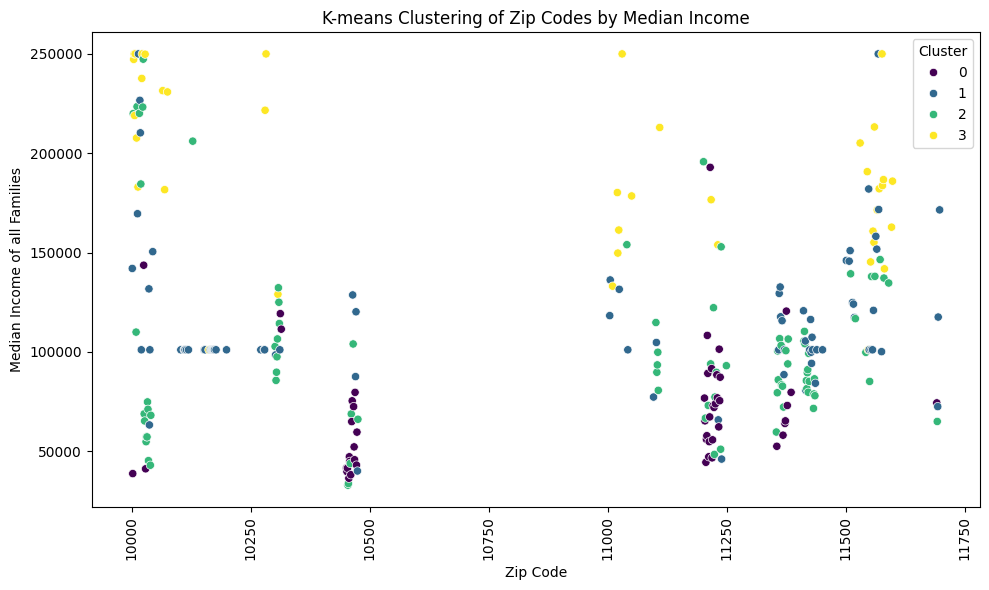

In [73]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the actual directory path to your data
data_path = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/processed/cleaned_data.csv'  # Update this to the correct path

# Step 0: Read the data into a pandas DataFrame
data = pd.read_csv(data_path)

# Step 1: Convert columns to numeric and handle missing values
numeric_cols = ['Number of Households', 'Number of Families', 
                'Number of Families with Children', 'Number of Families with NO Children', 
                'Families with no Earners', 'Percent Distribution of Families', 
                'Percent Distribution of Families with Children', 
                'Percent Distribution of Families with NO Children', 
                'Median Income of all Households', 'Median Income of all Families']

# Convert columns to numeric, coerce any errors to NaN
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Use an imputer to fill in any NaN values with the median of the column
imputer = SimpleImputer(strategy='median')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# Step 2: Scale the numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numeric_cols])

# Step 3: Determine the number of clusters using the Elbow Method
sum_of_squared_distances = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    sum_of_squared_distances.append(km.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# Step 4: Run K-means clustering with the chosen number of clusters
# (Based on the plot, let's say the optimal number is found to be 4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# Step 5: Analyze the Results
# Calculate the mean of each cluster
cluster_means = data.groupby('Cluster')[numeric_cols].mean()
print(cluster_means)

# Step 6: Visualization
# Create a scatter plot for visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Zip Code', y='Median Income of all Families', hue='Cluster', palette='viridis')
plt.title('K-means Clustering of Zip Codes by Median Income')
plt.legend(title='Cluster')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to fit the labels
plt.show()


In [74]:
import geopandas as gpd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your data with the longitude and latitude
data_path  = '/Users/alejandrodiaz/Documents/GitHub/DS_Project/data/processed/cleaned_data.csv'  # Update this to the correct path
data = pd.read_csv(data_path)

# Perform K-means clustering using latitude and longitude
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[['longitude', 'latitude']])

# Load the shapefile or GeoJSON file for the zip code boundaries
zip_shapes_path = '/path/to/your/zip_code_shapes.shp'  # Update this to the correct path
zip_shapes = gpd.read_file(zip_shapes_path)

# Merge the cluster data with the shape data
map_data = zip_shapes.merge(data, on='Zip Code')

# Plot the clusters on the map
fig, ax = plt.subplots(figsize=(15, 15))
map_data.plot(column='Cluster', categorical=True, legend=True, figsize=(10, 10), ax=ax)

# Remove axis off
ax.set_axis_off()

# Show the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/your/cleaned_data_with_lat_lon.csv'